# Toy 4 (Exponential): Follow the Authors' Built-in Functions

In [1]:
import torch
from kan import create_dataset
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.exp(-2 * x[:, [0]]) + x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

In [ ]:
model = MultKAN(width=[2,2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.002, lamb_entropy=2.)
model.plot()

In [ ]:
model = model.prune(edge_th=1e-2)
model.plot()

In [ ]:
grids = [3, 5, 10, 20, 50]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())


In [ ]:
n_params = np.array(grids) * (2*2+2*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

그냥 학습하는 것보다 조금씩 grid를 refine해가는 것이 성능을 좋게 한다.

아래는 매번 새로운 KAN을 정의하고 바로 처음부터 finer grid로 학습하는 예시.

오히려 grid가 많을수록 학습이 덜 되어서 정확도가 떨어진다.

In [ ]:
train_rmse_restart = []
test_rmse_restart = []

for i in range(len(grids)):
    model = MultKAN(width=[2,2,1], grid=grids[i], k=3, seed=0, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30)
    train_rmse_restart.append(results['train_loss'][-1].item())
    test_rmse_restart.append(results['test_loss'][-1].item())

n_params = np.array(grids) * (2*2+2*1)
plt.plot(n_params, train_rmse_restart, marker="o")
plt.plot(n_params, train_rmse_restart, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

배신: 사실 layer가 1단계만 있으면 바로 학습한다....

| train_loss: 1.42e-02 | test_loss: 1.49e-02 | reg: 2.21e+00 | : 100%|█| 20/20 [00:02<00:00,  9.48it
| train_loss: 3.15e-05 | test_loss: 3.66e-05 | reg: 4.65e+00 | : 100%|█| 50/50 [00:01<00:00, 30.45it


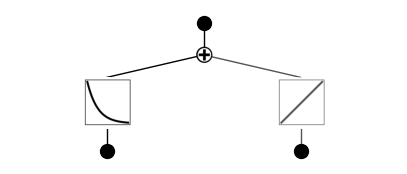

In [2]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [10]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

In [ ]:
from kan.custom_utils import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

In [3]:
model.auto_symbolic()

r2 is 1.0000003576278687
fixing (0,0,0) with exp, r2=1.0, c=2
r2 is 1.0000004768371582
fixing (0,1,0) with x, r2=1.0, c=1


In [4]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

0.5095*x_2 - 0.929 + 0.5095*exp(-2.0*x_1)